# Spring Mass System - All Combos for C


Set up the synamics of a spring mass system. also generate all possible combinations of rows of the C matrix.

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.linalg import expm
import itertools
import pandas as pd

# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)

# Continuous-time state-space matrices
A_c = np.array([[0, 1],
                [-k/m, -c/m]])
B_c = np.array([[0],
                [1/m]])

C = np.array([[1, 0],   # Measuring position
              [0, 1],   # Measuring velocity
              [1, 1]])  # New measurement (sum of position and velocity)

unique_combos = []
# Get all unique combinations of rows
num_rows = len(C)
for r in range(1, num_rows + 1):  # r determines subset size
    for combo in itertools.combinations(C, r):
        #print(np.array(combo))  # Each combo is a tuple of rows
        unique_combos.append(combo)

C_all = []

for combo in unique_combos:
    padded_combo = np.zeros((3, C.shape[1]), dtype=int)
    for i, row in enumerate(combo):
        padded_combo[i] = row
    C_all.append(padded_combo)
    print(padded_combo)
    print()

# Process and measurement noise
Q = np.array([[1e-4, 0], 
              [0, 1e-4]])  # Process noise covariance

R = np.array([[0.05, 0, 0], 
              [0, 0.05, 0],
              [0, 0, 0.05]])  # New row and column for extra measurement noise

# Discrete time system for kalman filter
dt = 0.1  # Time step
A_d = expm(A_c * dt)
B_d = np.linalg.solve(A_c, (A_d - np.eye(2))) @ B_c

# Initial conditions
x0 = np.array([1.0, 0.0])  # Initial displacement and velocity

[[1 0]
 [0 0]
 [0 0]]

[[0 1]
 [0 0]
 [0 0]]

[[1 1]
 [0 0]
 [0 0]]

[[1 0]
 [0 1]
 [0 0]]

[[1 0]
 [1 1]
 [0 0]]

[[0 1]
 [1 1]
 [0 0]]

[[1 0]
 [0 1]
 [1 1]]



Now, simulate the true system. 

In [120]:
# Simulate the system
np.random.seed(42)
n_steps = 100 
true_states = []
measurements = []
for _ in range(n_steps):
    # Simulate true dynamics
    x_true = A_d @ x0 + np.random.multivariate_normal([0, 0], Q).T
    true_states.append(x_true)

    # Simulate noisy measurements
    z = C @ x_true + np.random.multivariate_normal([0, 0, 0], R).T
    measurements.append(z)

    # Update for the next time step
    x0 = x_true

true_states = np.array(true_states)
measurements = np.array(measurements)

Then, use the kalman filter to generate state estimates for every combination of C. Make sure to use the 3 sigma range to set up the uncertainty range. 

In [121]:
nums = np.zeros(shape=(n_steps, 4))
data = []

for i in range(len(C_all)):
    kf = KalmanFilter(dim_x=2, dim_z=3)  # Changed dim_z to 3
    kf.F = A_d  # Discretized A matrix
    kf.H = C_all[i]  # Measurement matrix C
    kf.Q = Q  # Process noise covariance Q
    kf.R = R # Measurement noise covariance R
    kf.P = np.eye(2) * 500  # Initial state covariance P
    kf.x = x0  # Initial state estimate

    data_at_this_C = pd.DataFrame(nums, columns=['position', 'velocity', 'position uncertainty', 'velocity uncertainty'])

    for step, z in enumerate(measurements):
        kf.predict()
        kf.update(z)
        data_at_this_C.iloc[step, 0] = kf.x[0]
        data_at_this_C.iloc[step, 1] = kf.x[1]
        three_sigma = 3 * np.sqrt(np.diag(kf.P)) # make sure to multiply by 3 for 3 sigma!!
        data_at_this_C.iloc[step, 2] = three_sigma[0]
        data_at_this_C.iloc[step, 3] = three_sigma[1]
    data.append(data_at_this_C.copy())

Plotting    

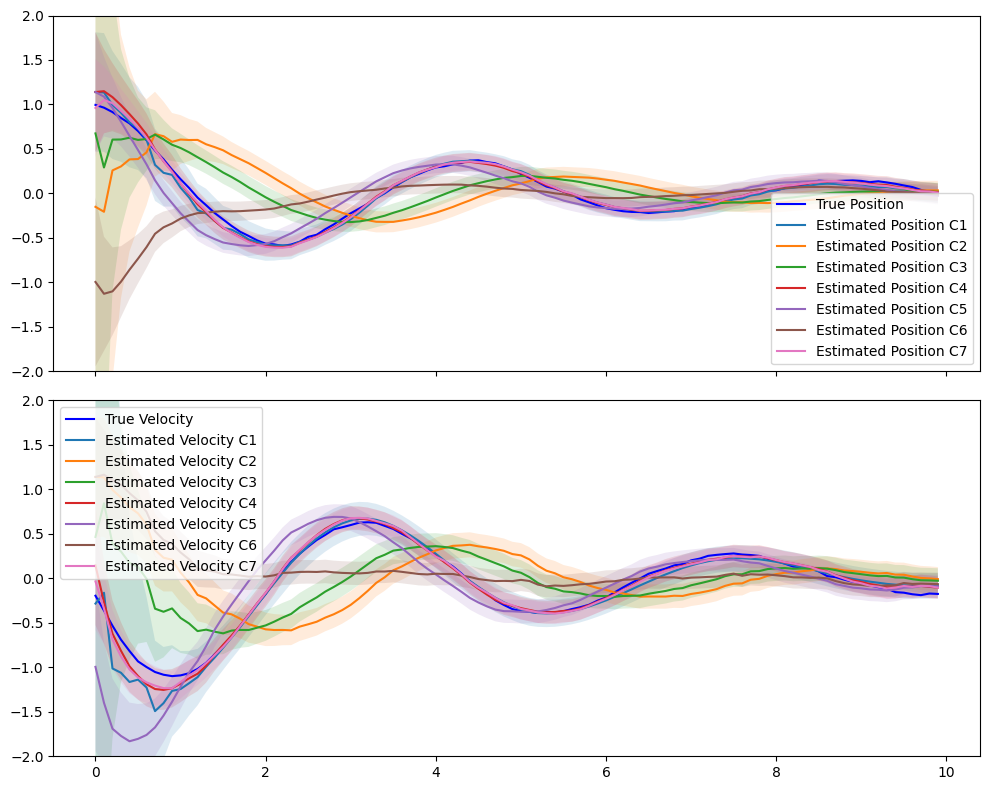

In [122]:
# Plot results from the data dataframe
time = np.arange(0, n_steps * dt, dt)
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(time, true_states[:, 0], label="True Position", color="blue")
for i in range(len(data)):
    position_array = np.array(data[i]['position'])
    axs[0].plot(time, position_array, label=f"Estimated Position C{i+1}")
    axs[0].fill_between(time, position_array - np.array(data[i]['position uncertainty']), position_array + np.array(data[i]['position uncertainty']), alpha=0.15)
axs[0].set_ylim(-2, 2)

axs[1].plot(time, true_states[:, 1], label="True Velocity", color="blue")
for i in range(len(data)):
    velocity_array = np.array(data[i]['velocity'])
    axs[1].plot(time, velocity_array, label=f"Estimated Velocity C{i+1}")
    axs[1].fill_between(time, velocity_array - np.array(data[i]['velocity uncertainty']), velocity_array + np.array(data[i]['velocity uncertainty']), alpha=0.15)
axs[1].set_ylim(-2, 2)

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

I want to now check how much each state overlaps with the others. 

In [123]:
# cheeck if a state estimate for position overlaps with the uncertainty range of all other state estimates for position for at least 90% of the time and print results
for i in range(len(data)):
    for j in range(len(data)):
        if i != j:
            overlap = np.sum((data[i]['position'] + data[i]['position uncertainty'] > data[j]['position']) & (data[i]['position'] - data[i]['position uncertainty'] < data[j]['position'])) / len(data[i])
            print(f"Overlap of C{j+1} data in C{i+1} uncertainty range: {overlap:.2f}")
            if overlap > 0.9:
                print("Agreement: True")
            else:
                print("Agreement: False")
            print()

Overlap of C2 data in C1 uncertainty range: 0.28
Agreement: False

Overlap of C3 data in C1 uncertainty range: 0.47
Agreement: False

Overlap of C4 data in C1 uncertainty range: 1.00
Agreement: True

Overlap of C5 data in C1 uncertainty range: 0.80
Agreement: False

Overlap of C6 data in C1 uncertainty range: 0.46
Agreement: False

Overlap of C7 data in C1 uncertainty range: 1.00
Agreement: True

Overlap of C1 data in C2 uncertainty range: 0.30
Agreement: False

Overlap of C3 data in C2 uncertainty range: 0.72
Agreement: False

Overlap of C4 data in C2 uncertainty range: 0.30
Agreement: False

Overlap of C5 data in C2 uncertainty range: 0.30
Agreement: False

Overlap of C6 data in C2 uncertainty range: 0.36
Agreement: False

Overlap of C7 data in C2 uncertainty range: 0.31
Agreement: False

Overlap of C1 data in C3 uncertainty range: 0.40
Agreement: False

Overlap of C2 data in C3 uncertainty range: 0.69
Agreement: False

Overlap of C4 data in C3 uncertainty range: 0.37
Agreement: Fals

Now, do the same for velocity

In [124]:
# cheeck if a state estimate for velocity overlaps with the uncertainty range of all other state estimates for velocity for at least 90% of the time and print results. Do the same thing as the above block
for i in range(len(data)):
    for j in range(len(data)):
        if i != j:
            overlap = np.sum((data[i]['velocity'] + data[i]['velocity uncertainty'] > data[j]['velocity']) & (data[i]['velocity'] - data[i]['velocity uncertainty'] < data[j]['velocity'])) / len(data[i])
            print(f"Overlap of C{j+1} data in C{i+1} uncertainty range: {overlap:.2f}")
            if overlap > 0.9:
                print("Agreement: True")
            else:
                print("Agreement: False")
            print()

Overlap of C2 data in C1 uncertainty range: 0.34
Agreement: False

Overlap of C3 data in C1 uncertainty range: 0.46
Agreement: False

Overlap of C4 data in C1 uncertainty range: 1.00
Agreement: True

Overlap of C5 data in C1 uncertainty range: 0.73
Agreement: False

Overlap of C6 data in C1 uncertainty range: 0.42
Agreement: False

Overlap of C7 data in C1 uncertainty range: 1.00
Agreement: True

Overlap of C1 data in C2 uncertainty range: 0.29
Agreement: False

Overlap of C3 data in C2 uncertainty range: 0.62
Agreement: False

Overlap of C4 data in C2 uncertainty range: 0.25
Agreement: False

Overlap of C5 data in C2 uncertainty range: 0.19
Agreement: False

Overlap of C6 data in C2 uncertainty range: 0.45
Agreement: False

Overlap of C7 data in C2 uncertainty range: 0.24
Agreement: False

Overlap of C1 data in C3 uncertainty range: 0.42
Agreement: False

Overlap of C2 data in C3 uncertainty range: 0.67
Agreement: False

Overlap of C4 data in C3 uncertainty range: 0.39
Agreement: Fals